## 2. CNN networks for classing cats and dogs:
datasets download link: https://www.kaggle.com/c/dogs-vs-cats/data
Create folders as follows:


![](folders.jpg)

In [39]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Input, Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

# dimensions of our images.
img_width, img_height =150, 150

train_data_dir = './data/train/'
validation_data_dir = './data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
nb_epoch = 1 # please change it to about 50 if you have enough time or calculation ability

### Before playing with models, let's have a look at how data augmentation is done with ImageDataGenerator

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from PIL import Image
from PIL import *

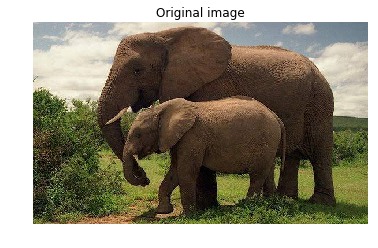

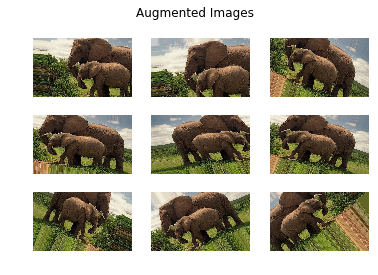

In [7]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
img = load_img('elephant.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('Original image')
plt.show()

x = img_to_array(img) # this is a Numpy array with shape ( 150, 150, 3)
x2 = x.reshape((1,)+x.shape) # this is a Numpy array with shape (1, 150, 150, 3)
# the .flow() command below generates batcher of randomly transformed image
# and saves the results to the "./data/data_augment" directory
i=0
fig =plt.figure()
fig.suptitle('Augmented Images')
for batch in datagen.flow(x2,batch_size=1,
                          save_to_dir='./data/data_augment',save_prefix='elephant',save_format='jpg'):
    i+=1
    if i>9:
        break # otherwise the generator would loop indefinitely
    temp = batch.reshape(x.shape)
    plt.subplot(3,3,i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

### Now we continue with the real data

In [45]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# This is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


### 2.1 Training a custom CNN from scratch

In [9]:
model = Sequential()
model.add(Convolution2D(32,(3,3),input_shape=(img_width,img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [10]:
model.fit_generator(
        train_generator,
        steps_per_epoch = nb_train_samples,
        epochs=nb_epoch,
        validation_data=validatioin_generator,
        validation_steps =nb_validation_samples)

Epoch 1/1
2000/2000 [==============================] - 356s - loss: 0.4691 - acc: 0.7715 - val_loss: 0.6644 - val_acc: 0.7435


### 2.2 Fine turning using pre-trained VGG16

### 2.2.1 Use pretrained VGG16 as a feature extractor

In [33]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input

input_tensor = Input((img_width, img_height, 3))
model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width,img_height),
        batch_size=100,
        class_mode=None,
        shuffle=False)

#bottleneck_features_train = model.predict_generator(generator,nb_train_samples)
bottleneck_features_train = model.predict_generator(generator,20)
print(bottleneck_features_train.shape)
np.save('bottleneck_features_train.npy', bottleneck_features_train)

Found 2000 images belonging to 2 classes.
(2000, 4, 4, 512)


In [34]:
generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=100,
        class_mode=None,
        shuffle=False)
#bottleneck_features_validation = model.predict_generator(generator,nb_validation_samples)
bottleneck_features_validation = model.predict_generator(generator,8)
print(bottleneck_features_validation.shape)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

Found 802 images belonging to 2 classes.
(800, 4, 4, 512)


In [35]:
train_data = np.load('bottleneck_features_train.npy')
validation_data = np.load('bottleneck_features_validation.npy')
print(train_data.shape,validation_data.shape)

#train_labels = np.array([0]*int((nb_train_samples/2))+[1]*int((nb_train_samples/2)))
#validation_labels = np.array([0]*int((nb_validation_samples/2))+[1]*int((nb_validation_samples/2)))

train_labels = np.array([0]*int((train_data.shape[0]/2))+[1]*int((train_data.shape[0]/2)))
validation_labels = np.array([0]*int((validation_data.shape[0]/2))+[1]*int((validation_data.shape[0]/2)))
print(train_labels.shape,validation_labels.shape)

(2000, 4, 4, 512) (800, 4, 4, 512)
(2000,) (800,)


In [37]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(train_data,train_labels,
          epochs = 50,
          batch_size=32,
          validation_data=(validation_data,validation_labels))
model.save_weights('top_model_weights.h5')

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 0s - loss: 0.8009 - acc: 0.7415 - val_loss: 0.2970 - val_acc: 0.8775
Epoch 2/50
2000/2000 [==============================] - 0s - loss: 0.3688 - acc: 0.8355 - val_loss: 0.2550 - val_acc: 0.8988
Epoch 3/50
2000/2000 [==============================] - 0s - loss: 0.3241 - acc: 0.8720 - val_loss: 0.2926 - val_acc: 0.8788
Epoch 4/50
2000/2000 [==============================] - 0s - loss: 0.3017 - acc: 0.8815 - val_loss: 0.2824 - val_acc: 0.8862
Epoch 5/50
2000/2000 [==============================] - 0s - loss: 0.2309 - acc: 0.9065 - val_loss: 0.2435 - val_acc: 0.9050
Epoch 6/50
2000/2000 [==============================] - 0s - loss: 0.2285 - acc: 0.9100 - val_loss: 0.2432 - val_acc: 0.9113
Epoch 7/50
2000/2000 [==============================] - 0s - loss: 0.1791 - acc: 0.9255 - val_loss: 0.2789 - val_acc: 0.9012
Epoch 8/50
2000/2000 [==============================] - 0s - loss: 0.1731 - ac

### 2.2.2 Use the weights of pretrained VGG16 as initialization

In [ ]:
input_tensor = Input((img_width,img_height,3))
model = VGG16(include_top=False, weights='imagenet',input_tensor=input_tensor)

vgg_input = model.input
vgg_output = model.output
top_model = Flatten()(vgg_output)
top_model = Dense(256,activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1,activation='sigmoid')(top_model)

model = Model(vgg_input,top_model)

model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

model.fit_generator(
        train_generator,
        steps_per_epoch = nb_train_samples,
        epochs= 2, # please change 2 to 50 for high performance
        validation_data = validation_generator,
        validation_steps = nb_validation_samples)


Epoch 1/2
2000/2000 [==============================] - 405s - loss: 0.1967 - acc: 0.8986 - val_loss: 0.1504 - val_acc: 0.9515
Epoch 2/2
1999/2000 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9973